In [2]:
#imports 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
import time 

In [3]:
#get the data_set
phish_data = pd.read_csv('datasets/phishing_site_urls.csv')

In [4]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [5]:
from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text  
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes  
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud

from bs4 import BeautifulSoup # use for scraping the data from website
from selenium import webdriver # use for automation chrome 
import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model 

In [6]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


<Axes: xlabel='Label', ylabel='Count'>

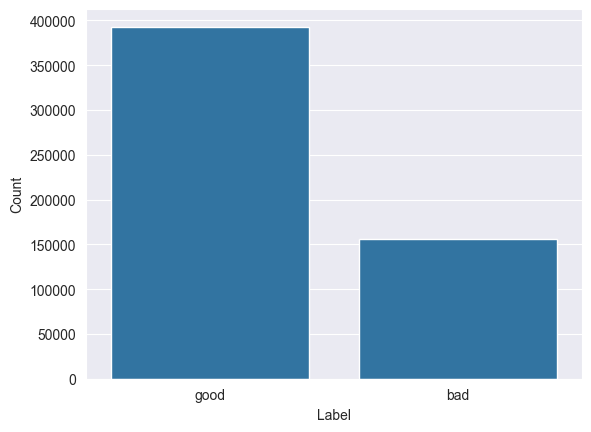

In [7]:
# Visualization
label_counts = pd.DataFrame(phish_data.Label.value_counts())
# Reset index to make the 'Label' counts as a column
label_counts.reset_index(inplace=True)
# Renaming the columns
label_counts.columns = ['Label', 'Count']
# Visualizing target_col
sns.set_style('darkgrid')
sns.barplot(x='Label', y='Count', data=label_counts)


In [8]:
#Tokenizing (removing irrelevant signs from the data)
tokenizer= RegexpTokenizer(r'[A-Za-z]+')


In [9]:
stemmer = SnowballStemmer("english") # choose a language


In [10]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 2.7334993000004033 sec


In [11]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 57.759260599999834 sec


In [12]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
361391,indeed.com/cmp/Live-Nation,good,"[indeed, com, cmp, Live, Nation]","[inde, com, cmp, live, nation]"
47985,www.ssmf.co.uk//login.aspx.htm,bad,"[www, ssmf, co, uk, login, aspx, htm]","[www, ssmf, co, uk, login, aspx, htm]"
367062,justweb.com.au/post-code/australia.html,good,"[justweb, com, au, post, code, australia, html]","[justweb, com, au, post, code, australia, html]"
192212,genealogysurnames.net/ChapmanCemeteryStones.html,good,"[genealogysurnames, net, ChapmanCemeteryStones...","[genealogysurnam, net, chapmancemeteryston, html]"
195378,guitar-lessons.meetup.com/,good,"[guitar, lessons, meetup, com]","[guitar, lesson, meetup, com]"


In [13]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.2919388999998773 sec


In [14]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
45374,www.ssl-240.mx/js/webapps/uk/mpp/?cmnd=_lg,bad,"[www, ssl, mx, js, webapps, uk, mpp, cmnd, lg]","[www, ssl, mx, js, webapp, uk, mpp, cmnd, lg]",www ssl mx js webapp uk mpp cmnd lg
312005,dailymotion.com/video/xg9nof_tim-hecker-border...,good,"[dailymotion, com, video, xg, nof, tim, hecker...","[dailymot, com, video, xg, nof, tim, hecker, b...",dailymot com video xg nof tim hecker borderlan...
464706,wikiporno.org/wiki/Trans_X_4,good,"[wikiporno, org, wiki, Trans, X]","[wikiporno, org, wiki, tran, x]",wikiporno org wiki tran x
244461,sullybaseball.blogspot.com/2009/01/i-miss-mont...,good,"[sullybaseball, blogspot, com, i, miss, montre...","[sullybasebal, blogspot, com, i, miss, montrea...",sullybasebal blogspot com i miss montreal expo...
150993,blogs.babycenter.com/products_and_prizes/disne...,good,"[blogs, babycenter, com, products, and, prizes...","[blog, babycent, com, product, and, prize, dis...",blog babycent com product and prize disney jun...


In [15]:
#slicing the data
bad_sites= phish_data[phish_data.Label=='bad']
good_sites= phish_data[phish_data.Label=='good'] 

In [16]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [17]:
from selenium import webdriver
browser = webdriver.Chrome()

In [18]:
list_urls = ['https://ezeephones.com.siteindices.com/','https://www.ezeephones.com/about-us'] #here i take phishing sites 
links_with_text = []

In [19]:
for url in list_urls:
    browser.get(url)
    soup = BeautifulSoup(browser.page_source,"html.parser")
    for line in soup.find_all('a'):
        href = line.get('href')
        links_with_text.append([url, href])

In [20]:
df = pd.DataFrame(links_with_text, columns=["from", "to"])
df.head()


,from,to
0,https://ezeephones.com.siteindices.com/,https://www.siteindices.com/
1,https://ezeephones.com.siteindices.com/,https://www.siteindices.com/explore
2,https://ezeephones.com.siteindices.com/,https://www.siteindices.com/privacy
3,https://ezeephones.com.siteindices.com/,https://ezeephones.com.siteindices.com
4,https://ezeephones.com.siteindices.com/,https://falachico.org.siteindices.com


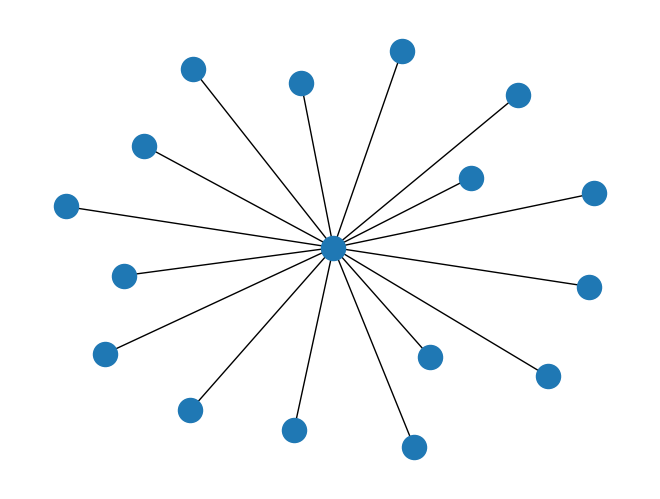

In [21]:
GA = nx.from_pandas_edgelist(df, source="from", target="to")
nx.draw(GA, with_labels=False)

In [22]:
#Countervectorize to make vector form of X axis features
cv = CountVectorizer()
feature = cv.fit_transform(phish_data.text_sent)

In [23]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
#Splitting into train and test set
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)


In [25]:
#check logisitic accuracy
lr= LogisticRegression()
lr.fit(trainX,trainY)
lr.score(testX,testY)

c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9637315508566519

In [26]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

In [27]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))

Training Accuracy : 0.9779276666286416
Testing Accuracy : 0.9637315508566519



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.90      0.97      0.93     36384
        Good       0.99      0.96      0.98    100953

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.97      0.96      0.96    137337


CONFUSION MATRIX


<Axes: >

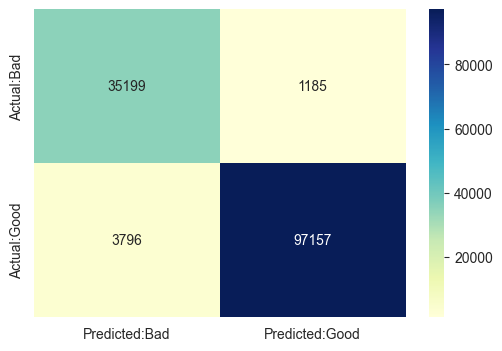

In [28]:
#Confusion matrix for Lr 
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [29]:
#Making sklearn pipeline
pipeline_ls = make_pipeline(CountVectorizer(tokenizer=RegexpTokenizer(r'[A-Za-z]+').tokenize, stop_words='english'), LogisticRegression())

In [30]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)


In [31]:
pipeline_ls.fit(trainX,trainY)


c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Arjun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [32]:
pipeline_ls.score(testX,testY) 

0.9656756737077408

Training Accuracy : 0.980381496520707
Testing Accuracy : 0.9656756737077408

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36775
        Good       0.99      0.96      0.98    100562

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


<Axes: >

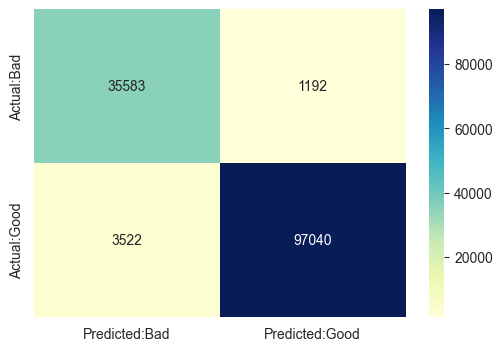

In [33]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [34]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [36]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9656756737077408


In [38]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['google.com' ,'amazon.com','youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good' 'good' 'good']
